# Module

In [123]:
import os, sys, urllib, warnings, errno, logging, time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import torch.nn as nn

In [124]:
sys.path.append('/content/drive/MyDrive/Research2021/IAF')

In [125]:
from two_barycenter import *
from util import create_deep_tree_cd
from metrics import *

from ddl.base import (CompositeDestructor, DestructorMixin, create_inverse_transformer, 
                      BoundaryWarning, DataConversionWarning, IdentityDestructor)
from ddl.independent import IndependentDensity, IndependentDestructor, IndependentInverseCdf
from ddl.linear import LinearProjector
from ddl.univariate import HistogramUnivariateDensity, ScipyUnivariateDensity
from ddl.deep import DeepDestructor
from ddl.linear import LinearProjector, RandomOrthogonalEstimator, BestLinearReconstructionDestructor
from weakflow import *

warnings.simplefilter('ignore', BoundaryWarning) # Ignore boundary warnings from ddl
warnings.simplefilter('ignore', DataConversionWarning) # Ignore data conversion warnings from ddl

In [126]:
saving_dir = '/content/drive/MyDrive/Research2021/IAF/figures/two_toy'

# Moon

Train (2000, 2), Test: (1000, 2))


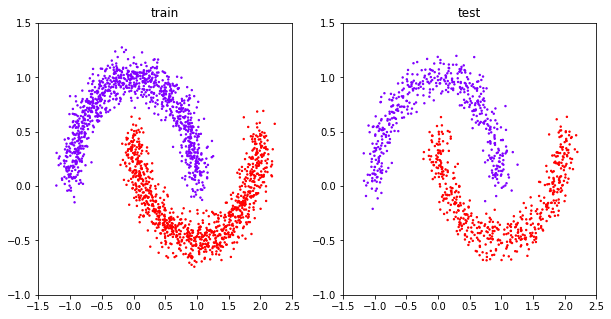

In [127]:
# Make data
# rng = np.random.RandomState(0)
# X, y = make_moons(n_samples=3000, noise=0.1, random_state=rng)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2000, random_state=rng)
# torch.save(X_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
# torch.save(y_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
# torch.save(X_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
# torch.save(y_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

# Load data
X_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
y_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
X_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
y_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

print(f'Train {X_train.shape}, Test: {X_test.shape})')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*X_train.T, c=y_train, s=2, cmap='rainbow')
ax1.set_title('train')
ax2.scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
ax2.set_title('test')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

## Training

Eight models are trained here.

In [128]:
# rearrange the data
class_list = [0,1]
n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_train[y_train==0,:]
X0 = X_train[np.nonzero(y_train==0)[0]]
X0 = X0[:n_samples]
y0 = y_train[np.nonzero(y_train==0)[0]]
y0 = y0[:n_samples]
X1 = X_train[np.nonzero(y_train==1)[0]]
X1 = X1[:n_samples]
y1 = y_train[np.nonzero(y_train==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))

In [129]:
cd_dict = dict()

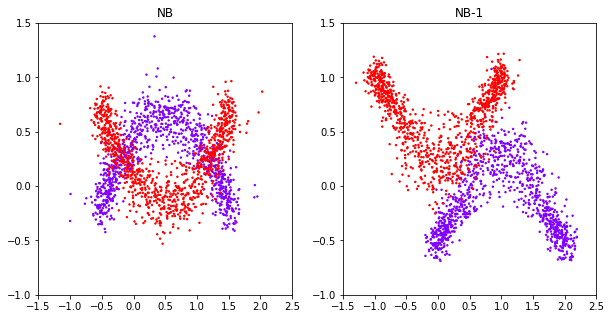

In [130]:
#NB

cd_nb = NaiveBaryClassifierDestructor()
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    Z_nb = cd_nb.fit_transform(X, y)
X_nb_flip = cd_nb.inverse_transform(Z_nb, 1 - y)
cd_dict['NB'] = cd_nb
del(cd_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_nb.T, c=y, s=2, cmap='rainbow')
ax1.set_title('NB')
ax2.scatter(*X_nb_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('NB-1')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

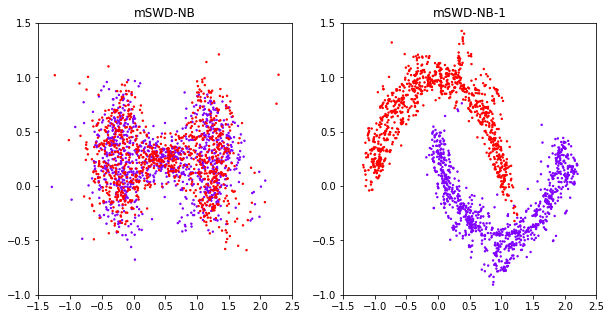

In [131]:
# mSWD-NB

n_layers = 15
cd_swd_nb = MSWDBaryClassifierDestructor()

Z_swd_nb = torch.clone(torch.Tensor(X))

for i in range(n_layers):
    cd_swd_nb, Z_swd_nb = add_one_layer(cd_swd_nb, Z_swd_nb, y, 'nb', ndim=2)
X_swd_nb_flip = cd_swd_nb.inverse(Z_swd_nb, 1 - y)

cd_dict['mSWD-NB'] = cd_swd_nb
del(cd_swd_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_swd_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('mSWD-NB')
ax2.scatter(*X_swd_nb_flip.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax2.set_title('mSWD-NB-1')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

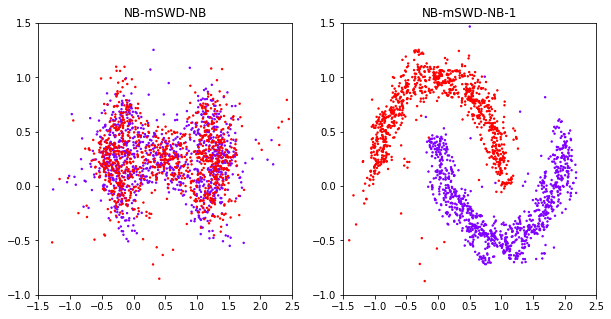

In [132]:
# NB followed by mSWD-NB

cd_nb_swd_nb = MSWDBaryClassifierDestructor()

Z_nb_swd_nb = torch.clone(torch.Tensor(X))

cd_nb_swd_nb, Z_nb_swd_nb = add_one_layer_ori(cd_nb_swd_nb, Z_nb_swd_nb, y, 'nb')

for i in range(n_layers-1):
    cd_nb_swd_nb, Z_nb_swd_nb = add_one_layer(cd_nb_swd_nb, Z_nb_swd_nb, y, 'nb', ndim=2)
X_nb_swd_nb_flip = cd_nb_swd_nb.inverse(Z_nb_swd_nb, 1 - y)

cd_dict['NB-mSWD-NB'] = cd_nb_swd_nb
del(cd_nb_swd_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_nb_swd_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('NB-mSWD-NB')
ax2.scatter(*X_nb_swd_nb_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('NB-mSWD-NB-1')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

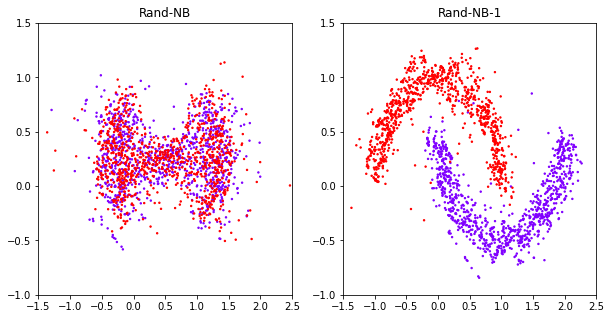

In [133]:
# random NB

cd_rand_nb = MSWDBaryClassifierDestructor()
Z_rand_nb = torch.clone(torch.Tensor(X))

for i in range(n_layers):
    
    cd_rand_nb, Z_rand_nb = add_one_layer(cd_rand_nb, Z_rand_nb, y, 'nb', ndim=2, rand=True)

X_rand_nb_flip = cd_rand_nb.inverse(Z_rand_nb, 1- y)

cd_dict['Rand-NB'] = cd_rand_nb
del(cd_rand_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_rand_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('Rand-NB')
ax2.scatter(*X_rand_nb_flip.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax2.set_title('Rand-NB-1')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

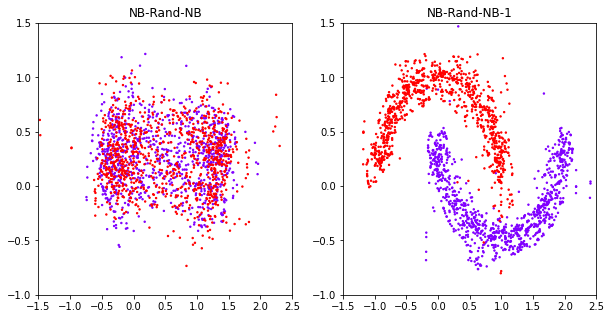

In [134]:
# NB followed by Random NB

cd_nb_rand_nb = MSWDBaryClassifierDestructor()

Z_nb_rand_nb = torch.clone(torch.Tensor(X))
cd_nb_rand_nb, Z_nb_rand_nb = add_one_layer_ori(cd_nb_rand_nb, Z_nb_rand_nb, y, 'nb')

for i in range(n_layers-1):
    cd_nb_rand_nb, Z_nb_rand_nb = add_one_layer(cd_nb_rand_nb, Z_nb_rand_nb, y, 'nb', ndim=2, rand=True)
X_nb_rand_nb_flip = cd_nb_rand_nb.inverse(Z_nb_rand_nb, 1-y)

cd_dict['NB-Rand-NB'] = cd_nb_rand_nb
del(cd_nb_rand_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_nb_rand_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('NB-Rand-NB')
ax2.scatter(*X_nb_rand_nb_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('NB-Rand-NB-1')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

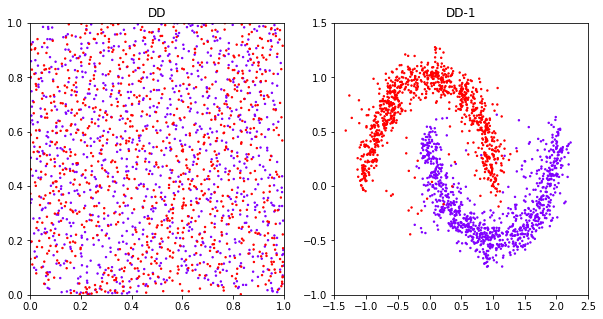

In [135]:
# Deep density destructors

copula_destructor = CompositeDestructor([
    IndependentInverseCdf(),
    LinearProjector(linear_estimator=RandomOrthogonalEstimator()),
    IndependentDestructor(),
    IndependentDestructor(IndependentDensity(HistogramUnivariateDensity(
        bins=40, bounds=[0, 1], alpha=1))),
])
cd_dd = DeepDestructor(
    init_destructor=DensityConditionalDestructor(
        density_destructor=IndependentDestructor()),
    canonical_destructor=DensityConditionalDestructor(
        density_destructor=copula_destructor),
    n_canonical_destructors=n_layers ,
    random_state=np.random.RandomState(0), # Random state set for all estimators
)


with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    Z_dd = cd_dd.fit_transform(X, y)
X_dd_flip = cd_dd.inverse_transform(Z_dd, 1 - y)

cd_dict['DD'] = cd_dd
del(cd_dd)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_dd.T, c=y, s=2, cmap='rainbow')
ax1.set_title('DD')
ax2.scatter(*X_dd_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('DD-1')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()


## Evaluation

In [136]:
# rearrange the data
n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
X0 = X_test[np.nonzero(y_test==0)[0]]
X0 = X0[:n_samples]
y0 = y_test[np.nonzero(y_test==0)[0]]
y0 = y0[:n_samples]
X1 = X_test[np.nonzero(y_test==1)[0]]
X1 = X1[:n_samples]
y1 = y_test[np.nonzero(y_test==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))

### Flipping

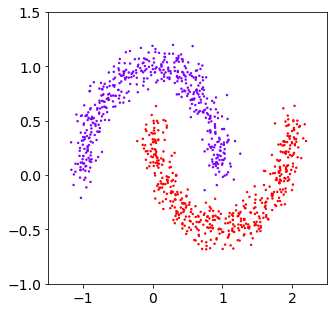

In [137]:
plt.figure(figsize=(5,5))
plt.scatter(*X.T, c=y, s=2, cmap='rainbow')
plt.tick_params(labelsize=14)
plt.xlim(-1.5,2.5)
plt.ylim(-1,1.5)
#plt.title('Original Test')
plt.savefig(saving_dir + '/moon_ori.png', bbox_inches='tight')
plt.show()

['NB', 'mSWD-NB', 'NB-mSWD-NB', 'Rand-NB', 'NB-Rand-NB', 'DD']


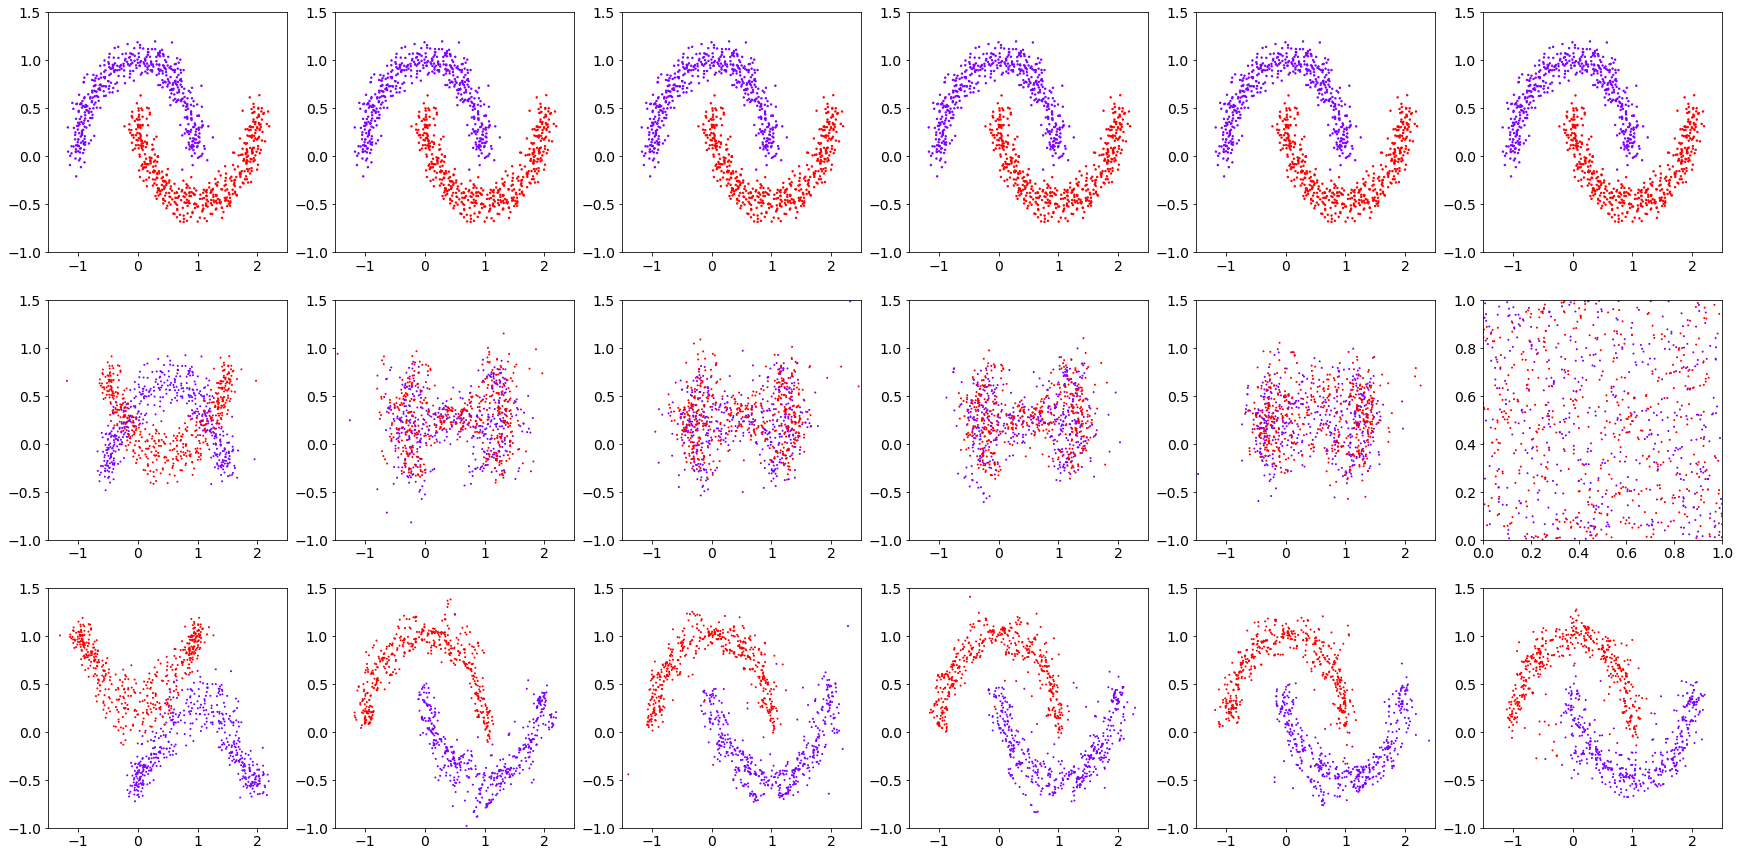

In [138]:

Z_dict = dict()
Xflip_dict = dict()

print(list(cd_dict))
fig, axs = plt.subplots(3,6,figsize=(30,15))
i=0
for key, cd in cd_dict.items():
    if key in ['GB', 'NB', 'DD','tree']:
        Z_temp = cd.transform(X, y)
        Xflip_temp = cd.inverse_transform(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp
    else:
        Z_temp = cd(X, y)
        Xflip_temp = cd.inverse(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp 
    
    axs[0,i].scatter(*X.T, c=y, s=2, cmap='rainbow')
    #axs[0,i].set_title('Original Test')

    try:
        axs[1,i].scatter(*Z_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[1,i].scatter(*Z_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')
    try:
        axs[2,i].scatter(*Xflip_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[2,i].scatter(*Xflip_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')

    axs[0,i].set_xlim(-1.5,2.5)
    axs[0,i].set_ylim(-1,1.5)
    axs[1,i].set_xlim(-1.5,2.5)
    axs[1,i].set_ylim(-1,1.5)
    axs[2,i].set_xlim(-1.5,2.5)
    axs[2,i].set_ylim(-1,1.5)
    axs[0,i].tick_params(labelsize=14)
    axs[2,i].tick_params(labelsize=14)
    axs[1,i].tick_params(labelsize=14)
    if key is 'DD':
        axs[1,i].set_xlim(0,1)
        axs[1,i].set_ylim(0,1)
    i += 1
plt.savefig(saving_dir + '/moon_flip.png', bbox_inches='tight')
plt.show()


mSWD-NB


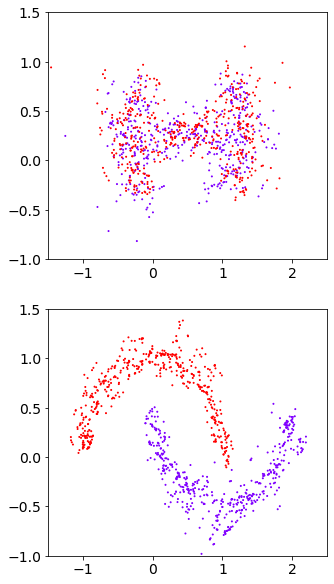

DD


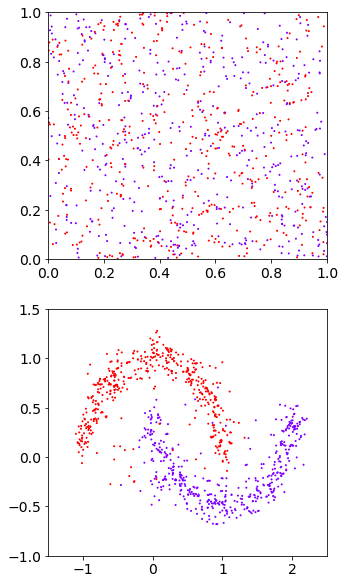

NB


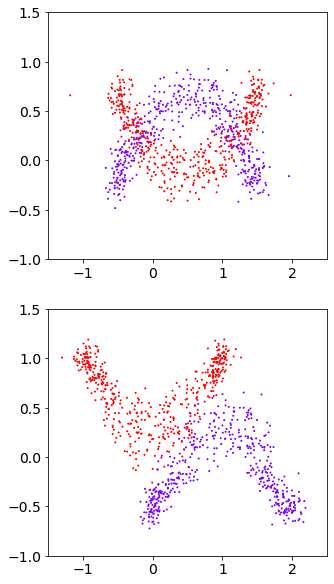

In [139]:
def gen_plot(cd_dict, key, X, y, path, show=False):
    print(key)
    cd = cd_dict[key]
    fig, axs = plt.subplots(2,1,figsize=(5,10))
    if key in ['GB', 'NB', 'DD','tree']:
        Z_temp = cd.transform(X, y)
        Xflip_temp = cd.inverse_transform(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp
    else:
        Z_temp = cd(X, y)
        Xflip_temp = cd.inverse(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp 

    axs[0].tick_params(labelsize=14)
    axs[1].tick_params(labelsize=14)
    axs[0].set_xlim(-1.5,2.5)
    axs[0].set_ylim(-1,1.5)
    axs[1].set_xlim(-1.5,2.5)
    axs[1].set_ylim(-1,1.5)
    if key is 'DD':
        axs[0].set_xlim(0,1)
        axs[0].set_ylim(0,1)
    try:
        axs[0].scatter(*Z_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[0].scatter(*Z_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')
    try:
        axs[1].scatter(*Xflip_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[1].scatter(*Xflip_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')
    plt.savefig(saving_dir + path, bbox_inches='tight')
    plt.show()

#gen_plot(cd_dict,'GB',X,y,'/moon_gb.png')
gen_plot(cd_dict,'mSWD-NB',X,y,'/moon_swdnb.png')
gen_plot(cd_dict,'DD',X,y,'/moon_dd.png')
#gen_plot(cd_dict,'tree',X,y,'/moon_tree.png')
gen_plot(cd_dict,'NB',X,y,'/moon_nb.png')

### Transport Cost

transportation cost of NB is 0.4012949466705322
transportation cost of mSWD-NB is 0.4785829186439514
transportation cost of NB-mSWD-NB is 0.4895634353160858
transportation cost of Rand-NB is 0.47499459981918335
transportation cost of NB-Rand-NB is 0.46646857261657715
transportation cost of DD is 1.2564365863800049


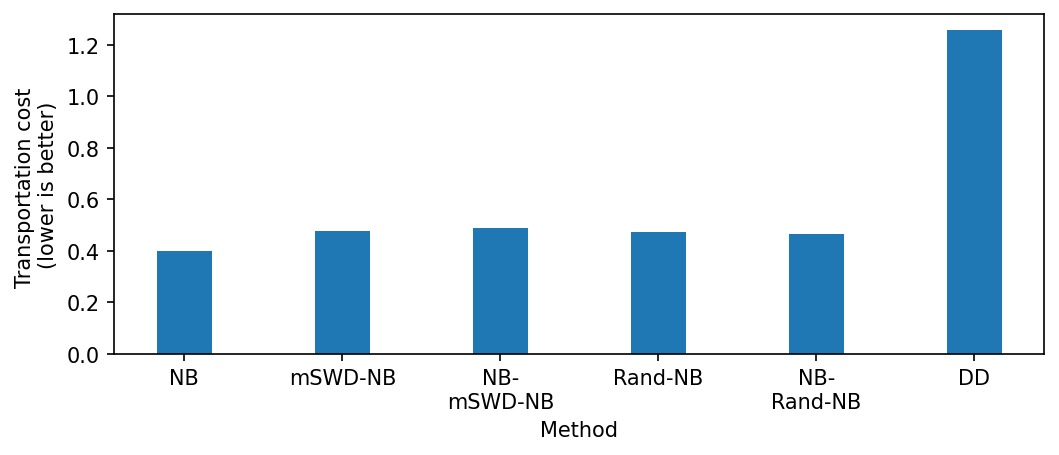

In [140]:
cost_dict = dict()
for key,Z in Z_dict.items():
    cost_temp = transport_cost(X, Z, y)
    cost_dict[key] = cost_temp
    print('transportation cost of '+key+f' is {cost_temp}')
    
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = [ 'NB', 'mSWD-NB', 'NB-\nmSWD-NB', 'Rand-NB', 'NB-\nRand-NB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(cost_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Transportation cost \n(lower is better)')
plt.show()

### Pushforward Constraint

2-wasserstein distance of NB in the latent space is 0.07564567774534225
2-wasserstein distance of mSWD-NB in the latent space is 0.012914026156067848
2-wasserstein distance of NB-mSWD-NB in the latent space is 0.03129623457789421
2-wasserstein distance of Rand-NB in the latent space is 0.011902298778295517
2-wasserstein distance of NB-Rand-NB in the latent space is 0.008885031566023827
2-wasserstein distance of DD in the latent space is 0.001018044538795948


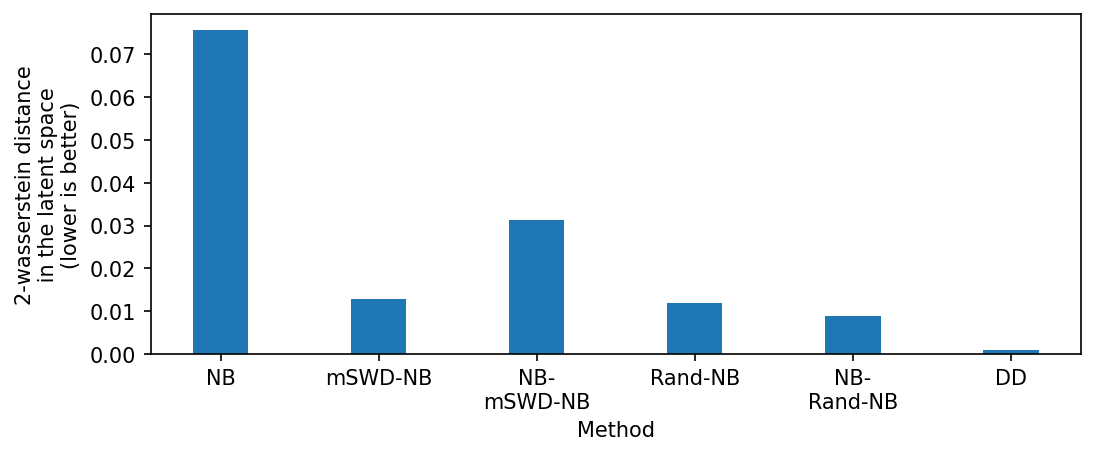

In [141]:
latentwd_dict = dict()
for key,Z in Z_dict.items():
    wd_temp = wd_sinkhorn(Z, y, n_samples).detach().numpy()
    latentwd_dict[key] = wd_temp
    print('2-wasserstein distance of '+key+f' in the latent space is {wd_temp}')

fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = [ 'NB', 'mSWD-NB', 'NB-\nmSWD-NB', 'Rand-NB', 'NB-\nRand-NB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(latentwd_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('2-wasserstein distance\n in the latent space \n(lower is better)')
plt.show()

2-wasserstein distance of NB in the original space is 0.07876361161470413
2-wasserstein distance of mSWD-NB in the original space is 0.0026470159646123648
2-wasserstein distance of NB-mSWD-NB in the original space is 0.003843743819743395
2-wasserstein distance of Rand-NB in the original space is 0.003514741314575076
2-wasserstein distance of NB-Rand-NB in the original space is 0.002923620631918311
2-wasserstein distance of DD in the original space is 0.008513290900737047


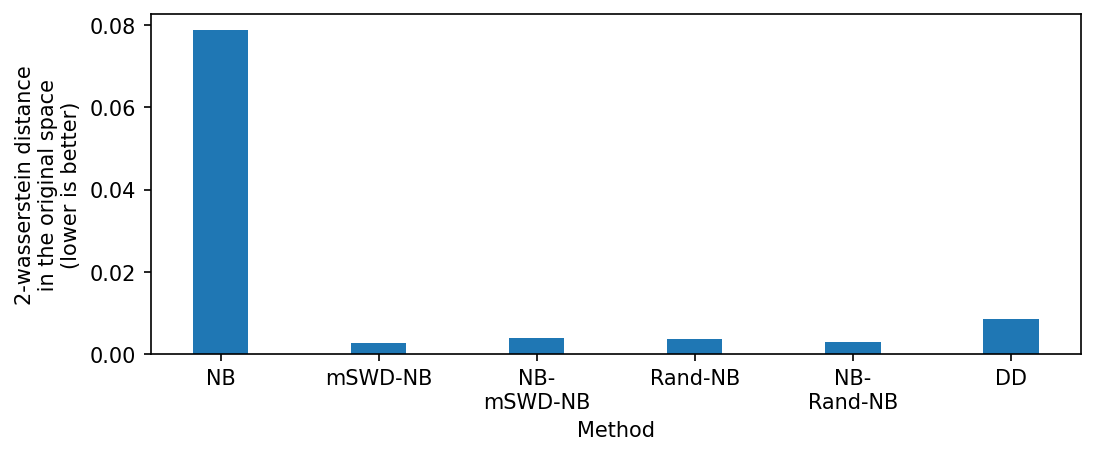

In [142]:
oriwd_dict = dict()
for key,Xflip in Xflip_dict.items():
    wd_temp = wd_average(X, Xflip, y, n_samples)
    oriwd_dict[key] = wd_temp
    print('2-wasserstein distance of '+key+f' in the original space is {wd_temp}')

fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = [ 'NB', 'mSWD-NB', 'NB-\nmSWD-NB', 'Rand-NB', 'NB-\nRand-NB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(oriwd_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('2-wasserstein distance\n in the original space \n(lower is better)')
plt.show()

# Random Pattern

Train (2000, 2), Test: (1000, 2))


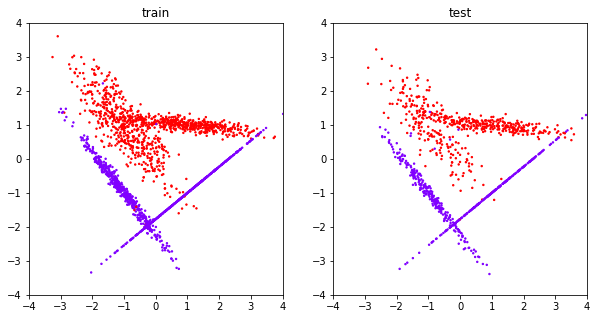

In [143]:
# #Make data
# rng = np.random.RandomState(0)
# X, y = make_classification(n_samples=3000, n_features=2, n_redundant=0, random_state=rng)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2000, random_state=rng)
# torch.save(X_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_X_train.pt')
# torch.save(y_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_y_train.pt')
# torch.save(X_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_X_test.pt')
# torch.save(y_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_y_test.pt')

# Load data
X_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_X_train.pt')
y_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_y_train.pt')
X_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_X_test.pt')
y_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_y_test.pt')

print(f'Train {X_train.shape}, Test: {X_test.shape})')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*X_train.T, c=y_train, s=2, cmap='rainbow')
ax1.set_title('train')
ax2.scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
ax2.set_title('test')
ax1.set_xlim(-4,4)
ax1.set_ylim(-4,4)
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)
plt.show()

## Training

Eight models are trained here.

In [144]:
# rearrange the data
class_list = [0,1]
n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_train[y_train==0,:]
X0 = X_train[np.nonzero(y_train==0)[0]]
X0 = X0[:n_samples]
y0 = y_train[np.nonzero(y_train==0)[0]]
y0 = y0[:n_samples]
X1 = X_train[np.nonzero(y_train==1)[0]]
X1 = X1[:n_samples]
y1 = y_train[np.nonzero(y_train==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))

In [145]:
cd_dict = dict()

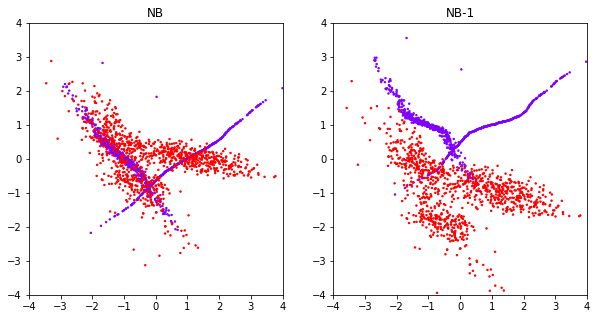

In [146]:
#NB

cd_nb = NaiveBaryClassifierDestructor()
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    Z_nb = cd_nb.fit_transform(X, y)
X_nb_flip = cd_nb.inverse_transform(Z_nb, 1 - y)
cd_dict['NB'] = cd_nb
del(cd_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_nb.T, c=y, s=2, cmap='rainbow')
ax1.set_title('NB')
ax2.scatter(*X_nb_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('NB-1')
ax1.set_xlim(-4,4)
ax1.set_ylim(-4,4)
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)
plt.show()

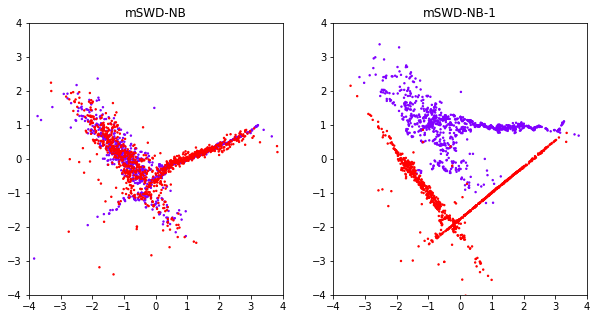

In [147]:
# mSWD-NB

n_layers = 15
cd_swd_nb = MSWDBaryClassifierDestructor()

Z_swd_nb = torch.clone(torch.Tensor(X))

for i in range(n_layers):
    cd_swd_nb, Z_swd_nb = add_one_layer(cd_swd_nb, Z_swd_nb, y, 'nb', ndim=2)
X_swd_nb_flip = cd_swd_nb.inverse(Z_swd_nb, 1 - y)

cd_dict['mSWD-NB'] = cd_swd_nb
del(cd_swd_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_swd_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('mSWD-NB')
ax2.scatter(*X_swd_nb_flip.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax2.set_title('mSWD-NB-1')
ax1.set_xlim(-4,4)
ax1.set_ylim(-4,4)
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)
plt.show()

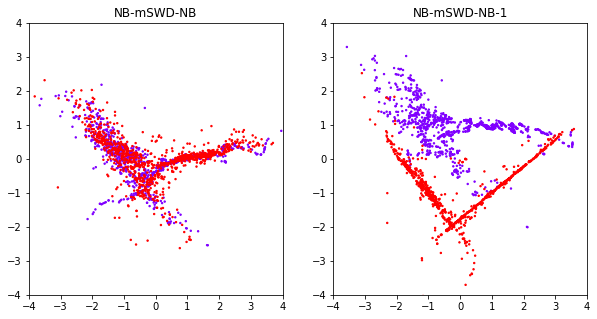

In [148]:
# NB followed by mSWD-NB

cd_nb_swd_nb = MSWDBaryClassifierDestructor()

Z_nb_swd_nb = torch.clone(torch.Tensor(X))

cd_nb_swd_nb, Z_nb_swd_nb = add_one_layer_ori(cd_nb_swd_nb, Z_nb_swd_nb, y, 'nb')

for i in range(n_layers-1):
    cd_nb_swd_nb, Z_nb_swd_nb = add_one_layer(cd_nb_swd_nb, Z_nb_swd_nb, y, 'nb', ndim=2)
X_nb_swd_nb_flip = cd_nb_swd_nb.inverse(Z_nb_swd_nb, 1 - y)

cd_dict['NB-mSWD-NB'] = cd_nb_swd_nb
del(cd_nb_swd_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_nb_swd_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('NB-mSWD-NB')
ax2.scatter(*X_nb_swd_nb_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('NB-mSWD-NB-1')
ax1.set_xlim(-4,4)
ax1.set_ylim(-4,4)
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)
plt.show()

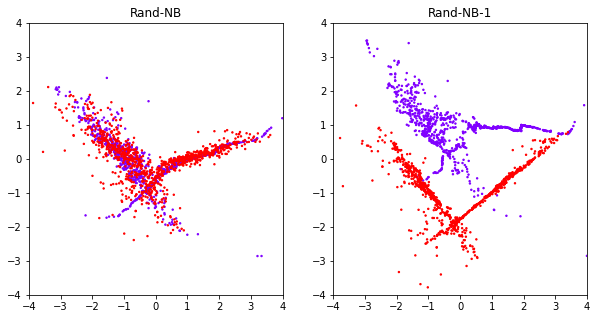

In [149]:
# random NB

cd_rand_nb = MSWDBaryClassifierDestructor()
Z_rand_nb = torch.clone(torch.Tensor(X))

for i in range(n_layers):
    cd_rand_nb, Z_rand_nb = add_one_layer(cd_rand_nb, Z_rand_nb, y, 'nb', ndim=2, rand=True)

X_rand_nb_flip = cd_rand_nb.inverse(Z_rand_nb, 1- y)

cd_dict['Rand-NB'] = cd_rand_nb
del(cd_rand_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_rand_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('Rand-NB')
ax2.scatter(*X_rand_nb_flip.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax2.set_title('Rand-NB-1')
ax1.set_xlim(-4,4)
ax1.set_ylim(-4,4)
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)
plt.show()

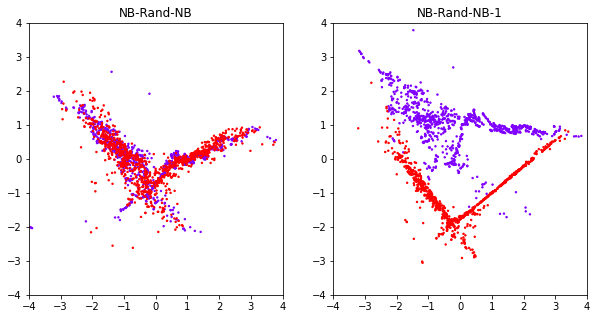

In [150]:
# NB followed by Random NB

cd_nb_rand_nb = MSWDBaryClassifierDestructor()

Z_nb_rand_nb = torch.clone(torch.Tensor(X))
cd_nb_rand_nb, Z_nb_rand_nb = add_one_layer_ori(cd_nb_rand_nb, Z_nb_rand_nb, y, 'nb')

for i in range(n_layers-1):
    cd_nb_rand_nb, Z_nb_rand_nb = add_one_layer(cd_nb_rand_nb, Z_nb_rand_nb, y, 'nb', ndim=2, rand=True)
X_nb_rand_nb_flip = cd_nb_rand_nb.inverse(Z_nb_rand_nb, 1-y)

cd_dict['NB-Rand-NB'] = cd_nb_rand_nb
del(cd_nb_rand_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_nb_rand_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('NB-Rand-NB')
ax2.scatter(*X_nb_rand_nb_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('NB-Rand-NB-1')
ax1.set_xlim(-4,4)
ax1.set_ylim(-4,4)
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)
plt.show()

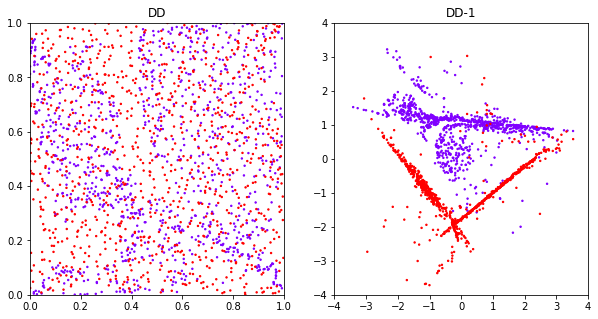

In [151]:
# Deep density destructors

copula_destructor = CompositeDestructor([
    IndependentInverseCdf(),
    LinearProjector(linear_estimator=RandomOrthogonalEstimator()),
    IndependentDestructor(),
    IndependentDestructor(IndependentDensity(HistogramUnivariateDensity(
        bins=40, bounds=[0, 1], alpha=1))),
])
cd_dd = DeepDestructor(
    init_destructor=DensityConditionalDestructor(
        density_destructor=IndependentDestructor()),
    canonical_destructor=DensityConditionalDestructor(
        density_destructor=copula_destructor),
    n_canonical_destructors=n_layers ,
    random_state=np.random.RandomState(0), # Random state set for all estimators
)


with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    Z_dd = cd_dd.fit_transform(X, y)
X_dd_flip = cd_dd.inverse_transform(Z_dd, 1 - y)

cd_dict['DD'] = cd_dd
del(cd_dd)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_dd.T, c=y, s=2, cmap='rainbow')
ax1.set_title('DD')
ax2.scatter(*X_dd_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('DD-1')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)
plt.show()


## Evaluation

In [152]:
# rearrange the data
n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
X0 = X_test[np.nonzero(y_test==0)[0]]
X0 = X0[:n_samples]
y0 = y_test[np.nonzero(y_test==0)[0]]
y0 = y0[:n_samples]
X1 = X_test[np.nonzero(y_test==1)[0]]
X1 = X1[:n_samples]
y1 = y_test[np.nonzero(y_test==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))

In [153]:
X.shape

(988, 2)

### Flipping

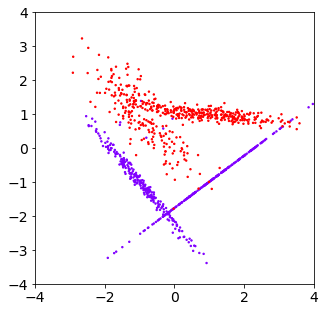

In [154]:
plt.figure(figsize=(5,5))
plt.scatter(*X.T, c=y, s=2, cmap='rainbow')
plt.tick_params(labelsize=14)
plt.xlim(-4,4)
plt.ylim(-4,4)
#plt.title('Original Test')
plt.savefig(saving_dir + '/random_ori.png', bbox_inches='tight')
plt.show()

['NB', 'mSWD-NB', 'NB-mSWD-NB', 'Rand-NB', 'NB-Rand-NB', 'DD']


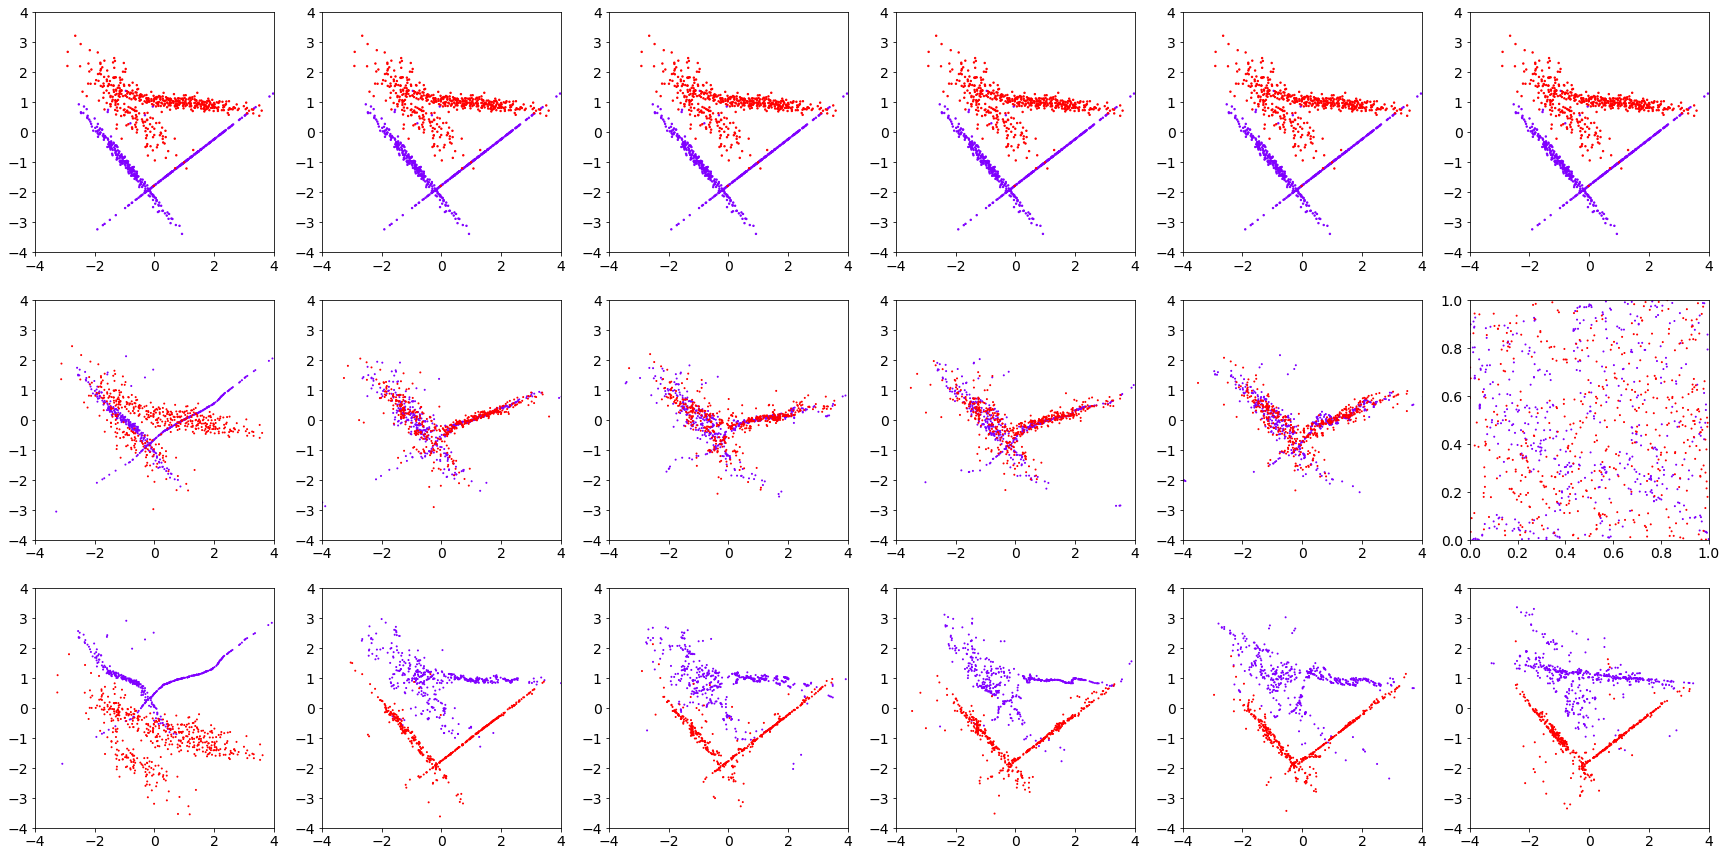

In [155]:
Z_dict = dict()
Xflip_dict = dict()

print(list(cd_dict))
fig, axs = plt.subplots(3,6,figsize=(30,15))
i=0
for key, cd in cd_dict.items():
    if key in ['GB', 'NB', 'DD','tree']:
        Z_temp = cd.transform(X, y)
        Xflip_temp = cd.inverse_transform(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp
    else:
        Z_temp = cd(X, y)
        Xflip_temp = cd.inverse(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp 
    
    axs[0,i].scatter(*X.T, c=y, s=2, cmap='rainbow')
    #axs[0,i].set_title('Original Test')

    try:
        axs[1,i].scatter(*Z_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[1,i].scatter(*Z_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')
    try:
        axs[2,i].scatter(*Xflip_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[2,i].scatter(*Xflip_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')

    axs[0,i].set_xlim(-4,4)
    axs[0,i].set_ylim(-4,4)
    axs[1,i].set_xlim(-4,4)
    axs[1,i].set_ylim(-4,4)
    axs[2,i].set_xlim(-4,4)
    axs[2,i].set_ylim(-4,4)
    axs[0,i].tick_params(labelsize=14)
    axs[2,i].tick_params(labelsize=14)
    axs[1,i].tick_params(labelsize=14)
    if key is 'DD':
        axs[1,i].set_xlim(0,1)
        axs[1,i].set_ylim(0,1)
    i += 1
plt.savefig(saving_dir + '/random_flip.png', bbox_inches='tight')
plt.show()


NB


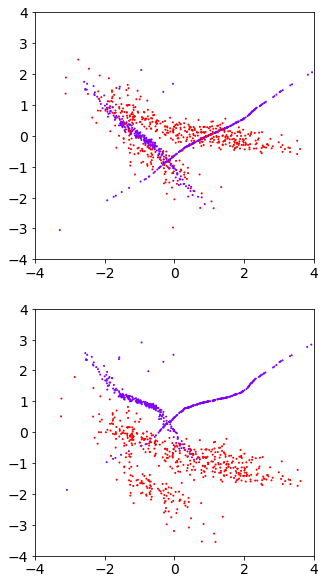

mSWD-NB


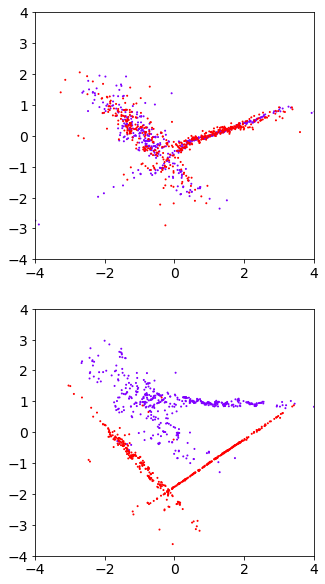

DD


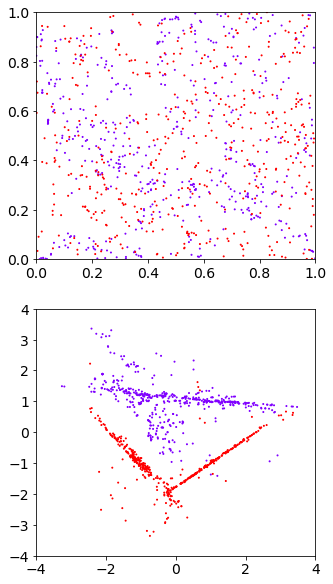

In [156]:
def gen_plot(cd_dict, key, X, y, path, show=False):
    print(key)
    cd = cd_dict[key]
    fig, axs = plt.subplots(2,1,figsize=(5,10))
    if key in ['GB', 'NB', 'DD','tree']:
        Z_temp = cd.transform(X, y)
        Xflip_temp = cd.inverse_transform(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp
    else:
        Z_temp = cd(X, y)
        Xflip_temp = cd.inverse(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp 

    axs[0].tick_params(labelsize=14)
    axs[1].tick_params(labelsize=14)
    axs[0].set_xlim(-4,4)
    axs[0].set_ylim(-4,4)
    axs[1].set_xlim(-4,4)
    axs[1].set_ylim(-4,4)
    if key is 'DD':
        axs[0].set_xlim(0,1)
        axs[0].set_ylim(0,1)
    try:
        axs[0].scatter(*Z_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[0].scatter(*Z_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')
    try:
        axs[1].scatter(*Xflip_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[1].scatter(*Xflip_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')
    plt.savefig(saving_dir + path , bbox_inches='tight')
    plt.show()

#gen_plot(cd_dict,'GB',X,y,'/random_gb.png')
gen_plot(cd_dict,'NB',X,y,'/random_nb.png')
gen_plot(cd_dict,'mSWD-NB',X,y,'/random_swdnb.png')
gen_plot(cd_dict,'DD',X,y,'/random_dd.png')
#gen_plot(cd_dict,'tree',X,y,'/random_tree.png')

### Transport Cost

transportation cost of NB is 0.953765869140625
transportation cost of mSWD-NB is 1.0082581043243408
transportation cost of NB-mSWD-NB is 1.0000699758529663
transportation cost of Rand-NB is 0.9973785281181335
transportation cost of NB-Rand-NB is 1.1024097204208374
transportation cost of DD is 3.700493335723877


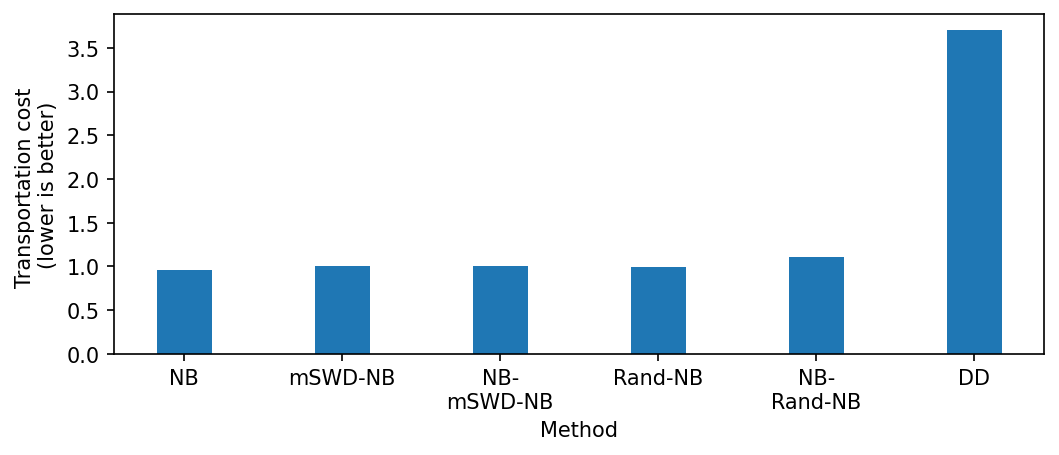

In [157]:
cost_dict = dict()
for key,Z in Z_dict.items():
    cost_temp = transport_cost(X, Z, y)
    cost_dict[key] = cost_temp
    print('transportation cost of '+key+f' is {cost_temp}')
    
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = [ 'NB', 'mSWD-NB', 'NB-\nmSWD-NB', 'Rand-NB', 'NB-\nRand-NB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(cost_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Transportation cost \n(lower is better)')
plt.show()

### Pushforward Constraint

2-wasserstein distance of NB in the latent space is 0.3106793463230133
2-wasserstein distance of mSWD-NB in the latent space is 0.07509829103946686
2-wasserstein distance of NB-mSWD-NB in the latent space is 0.037925418466329575
2-wasserstein distance of Rand-NB in the latent space is 0.03826536238193512
2-wasserstein distance of NB-Rand-NB in the latent space is 0.03336383402347565
2-wasserstein distance of DD in the latent space is 0.001639838796108961


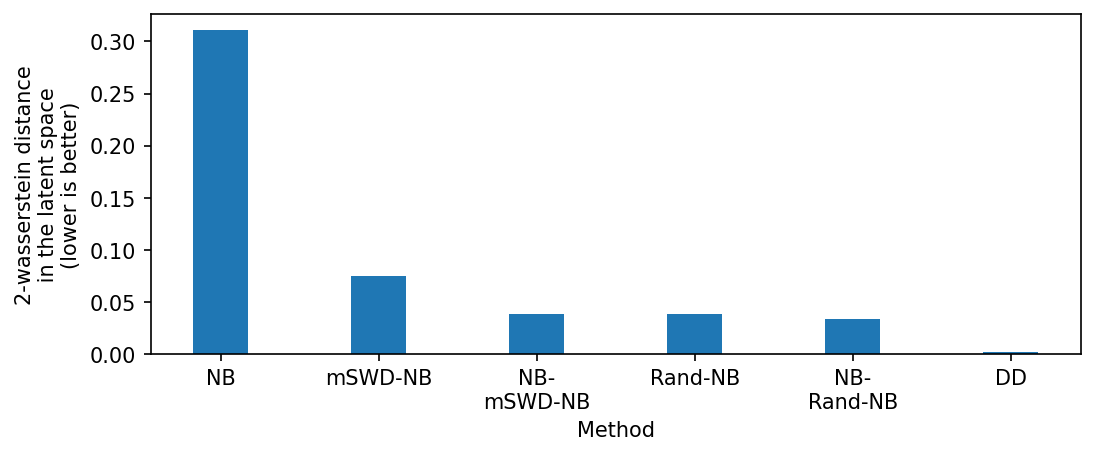

In [158]:
latentwd_dict = dict()
for key,Z in Z_dict.items():
    wd_temp = wd_sinkhorn(Z, y, n_samples).detach().numpy()
    latentwd_dict[key] = wd_temp
    print('2-wasserstein distance of '+key+f' in the latent space is {wd_temp}')

fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = [ 'NB', 'mSWD-NB', 'NB-\nmSWD-NB', 'Rand-NB', 'NB-\nRand-NB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(latentwd_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('2-wasserstein distance\n in the latent space \n(lower is better)')
plt.show()

2-wasserstein distance of NB in the original space is 0.3173211142420769
2-wasserstein distance of mSWD-NB in the original space is 0.026333730667829514
2-wasserstein distance of NB-mSWD-NB in the original space is 0.035092202946543694
2-wasserstein distance of Rand-NB in the original space is 0.06847787089645863
2-wasserstein distance of NB-Rand-NB in the original space is 0.049569545313715935
2-wasserstein distance of DD in the original space is 0.046928586438298225


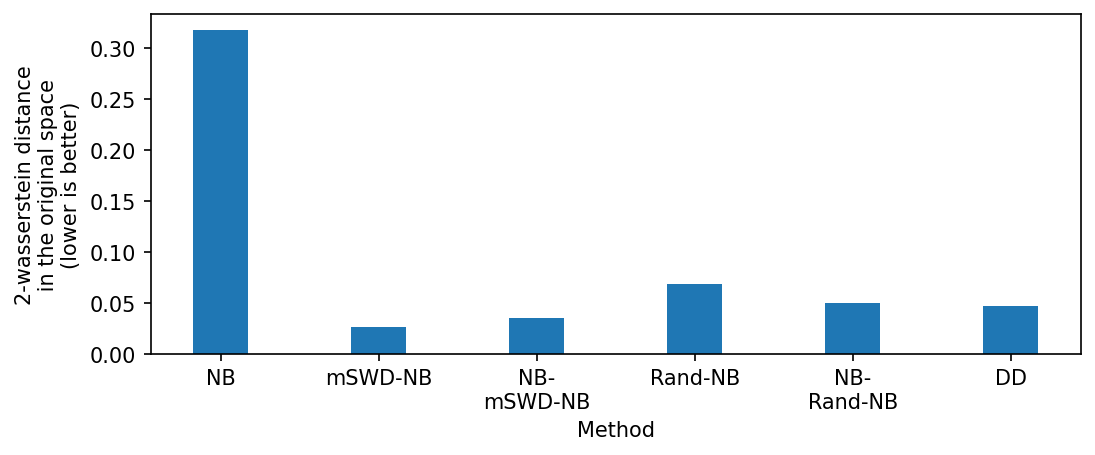

In [159]:
oriwd_dict = dict()
for key,Xflip in Xflip_dict.items():
    wd_temp = wd_average(X, Xflip, y, n_samples)
    oriwd_dict[key] = wd_temp
    print('2-wasserstein distance of '+key+f' in the original space is {wd_temp}')

fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = [ 'NB', 'mSWD-NB', 'NB-\nmSWD-NB', 'Rand-NB', 'NB-\nRand-NB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(oriwd_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('2-wasserstein distance\n in the original space \n(lower is better)')
plt.show()

# Concentric Circles

Train (2000, 2), Test: (1000, 2))


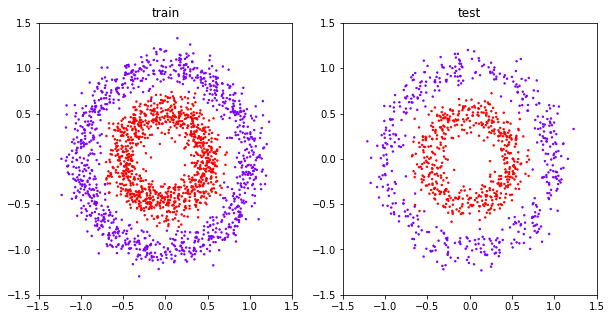

In [160]:
# Make data
# rng = np.random.RandomState(0)
# X, y = make_circles(n_samples=3000, factor=0.5,  noise=0.1, random_state=rng)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2000, random_state=rng)
# torch.save(X_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_X_train.pt')
# torch.save(y_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_y_train.pt')
# torch.save(X_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_X_test.pt')
# torch.save(y_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_y_test.pt')

# Load data
X_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_X_train.pt')
y_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_y_train.pt')
X_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_X_test.pt')
y_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_y_test.pt')

print(f'Train {X_train.shape}, Test: {X_test.shape})')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*X_train.T, c=y_train, s=2, cmap='rainbow')
ax1.set_title('train')
ax2.scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
ax2.set_title('test')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
plt.show()

## Training

Eight models are trained here.

In [161]:
# rearrange the data
class_list = [0,1]
n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_train[y_train==0,:]
X0 = X_train[np.nonzero(y_train==0)[0]]
X0 = X0[:n_samples]
y0 = y_train[np.nonzero(y_train==0)[0]]
y0 = y0[:n_samples]
X1 = X_train[np.nonzero(y_train==1)[0]]
X1 = X1[:n_samples]
y1 = y_train[np.nonzero(y_train==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))

In [162]:
cd_dict = dict()

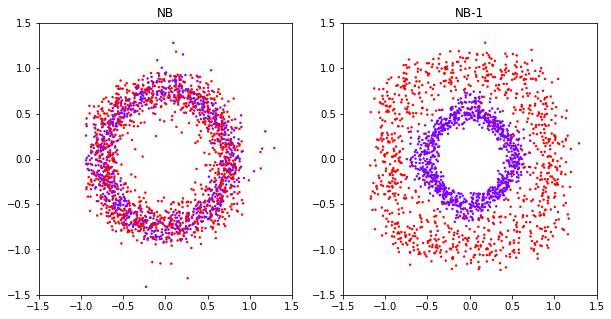

In [163]:
#NB

cd_nb = NaiveBaryClassifierDestructor()
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    Z_nb = cd_nb.fit_transform(X, y)
X_nb_flip = cd_nb.inverse_transform(Z_nb, 1 - y)
cd_dict['NB'] = cd_nb
del(cd_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_nb.T, c=y, s=2, cmap='rainbow')
ax1.set_title('NB')
ax2.scatter(*X_nb_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('NB-1')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
plt.show()

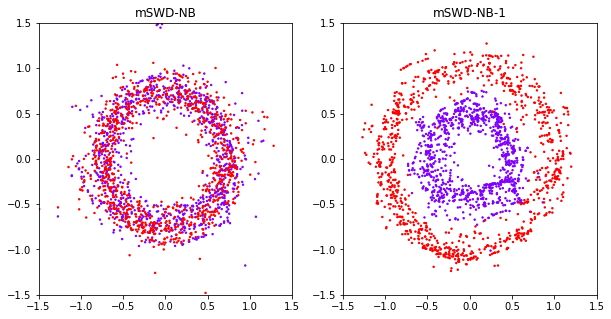

In [164]:
# mSWD-NB

n_layers = 15
cd_swd_nb = MSWDBaryClassifierDestructor()

Z_swd_nb = torch.clone(torch.Tensor(X))

for i in range(n_layers):
    cd_swd_nb, Z_swd_nb = add_one_layer(cd_swd_nb, Z_swd_nb, y, 'nb', ndim=2)
X_swd_nb_flip = cd_swd_nb.inverse(Z_swd_nb, 1 - y)

cd_dict['mSWD-NB'] = cd_swd_nb
del(cd_swd_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_swd_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('mSWD-NB')
ax2.scatter(*X_swd_nb_flip.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax2.set_title('mSWD-NB-1')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
plt.show()

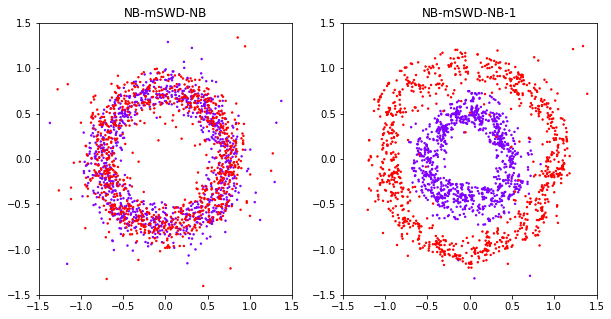

In [165]:
# NB followed by mSWD-NB

cd_nb_swd_nb = MSWDBaryClassifierDestructor()

Z_nb_swd_nb = torch.clone(torch.Tensor(X))

cd_nb_swd_nb, Z_nb_swd_nb = add_one_layer_ori(cd_nb_swd_nb, Z_nb_swd_nb, y, 'nb')

for i in range(n_layers-1):
    cd_nb_swd_nb, Z_nb_swd_nb = add_one_layer(cd_nb_swd_nb, Z_nb_swd_nb, y, 'nb', ndim=2)
X_nb_swd_nb_flip = cd_nb_swd_nb.inverse(Z_nb_swd_nb, 1 - y)

cd_dict['NB-mSWD-NB'] = cd_nb_swd_nb
del(cd_nb_swd_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_nb_swd_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('NB-mSWD-NB')
ax2.scatter(*X_nb_swd_nb_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('NB-mSWD-NB-1')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
plt.show()

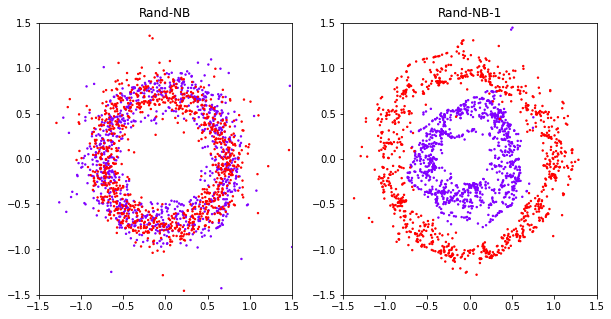

In [166]:
# random NB

cd_rand_nb = MSWDBaryClassifierDestructor()
Z_rand_nb = torch.clone(torch.Tensor(X))

for i in range(n_layers):
    cd_rand_nb, Z_rand_nb = add_one_layer(cd_rand_nb, Z_rand_nb, y, 'nb', ndim=2, rand=True)

X_rand_nb_flip = cd_rand_nb.inverse(Z_rand_nb, 1- y)

cd_dict['Rand-NB'] = cd_rand_nb
del(cd_rand_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_rand_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('Rand-NB')
ax2.scatter(*X_rand_nb_flip.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax2.set_title('Rand-NB-1')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
plt.show()

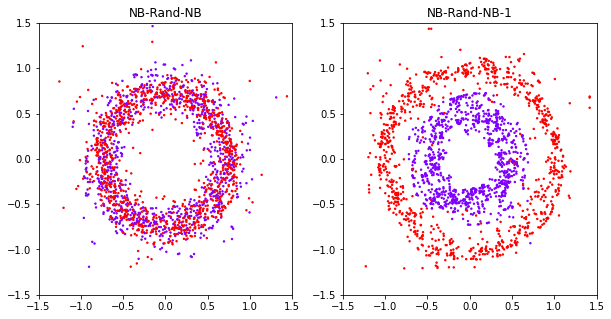

In [167]:
# NB followed by Random NB

cd_nb_rand_nb = MSWDBaryClassifierDestructor()

Z_nb_rand_nb = torch.clone(torch.Tensor(X))
cd_nb_rand_nb, Z_nb_rand_nb = add_one_layer_ori(cd_nb_rand_nb, Z_nb_rand_nb, y, 'nb')

for i in range(n_layers-1):
    cd_nb_rand_nb, Z_nb_rand_nb = add_one_layer(cd_nb_rand_nb, Z_nb_rand_nb, y, 'nb', ndim=2, rand=True)
X_nb_rand_nb_flip = cd_nb_rand_nb.inverse(Z_nb_rand_nb, 1-y)

cd_dict['NB-Rand-NB'] = cd_nb_rand_nb
del(cd_nb_rand_nb)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_nb_rand_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
ax1.set_title('NB-Rand-NB')
ax2.scatter(*X_nb_rand_nb_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('NB-Rand-NB-1')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
plt.show()

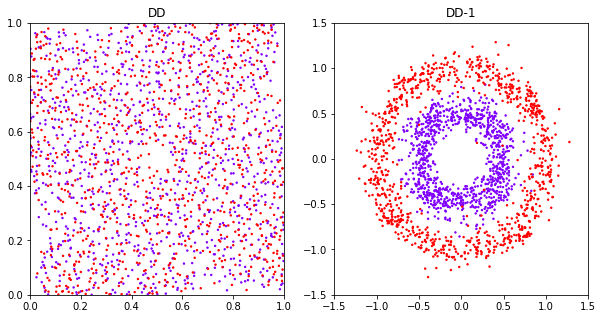

In [168]:
# Deep density destructors

copula_destructor = CompositeDestructor([
    IndependentInverseCdf(),
    LinearProjector(linear_estimator=RandomOrthogonalEstimator()),
    IndependentDestructor(),
    IndependentDestructor(IndependentDensity(HistogramUnivariateDensity(
        bins=40, bounds=[0, 1], alpha=1))),
])
cd_dd = DeepDestructor(
    init_destructor=DensityConditionalDestructor(
        density_destructor=IndependentDestructor()),
    canonical_destructor=DensityConditionalDestructor(
        density_destructor=copula_destructor),
    n_canonical_destructors=n_layers ,
    random_state=np.random.RandomState(0), # Random state set for all estimators
)


with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    Z_dd = cd_dd.fit_transform(X, y)
X_dd_flip = cd_dd.inverse_transform(Z_dd, 1 - y)

cd_dict['DD'] = cd_dd
del(cd_dd)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*Z_dd.T, c=y, s=2, cmap='rainbow')
ax1.set_title('DD')
ax2.scatter(*X_dd_flip.T, c=y, s=2, cmap='rainbow')
ax2.set_title('DD-1')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
plt.show()

## Evaluation

In [169]:
# rearrange the data
n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
X0 = X_test[np.nonzero(y_test==0)[0]]
X0 = X0[:n_samples]
y0 = y_test[np.nonzero(y_test==0)[0]]
y0 = y0[:n_samples]
X1 = X_test[np.nonzero(y_test==1)[0]]
X1 = X1[:n_samples]
y1 = y_test[np.nonzero(y_test==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))

### Flipping

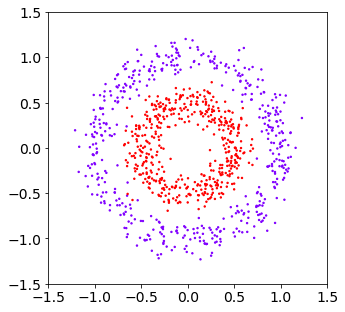

In [170]:
plt.figure(figsize=(5,5))
plt.scatter(*X.T, c=y, s=2, cmap='rainbow')
plt.tick_params(labelsize=14)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
#plt.title('Original Test')
plt.savefig(saving_dir + '/circle_ori.png', bbox_inches='tight')
plt.show()

['NB', 'mSWD-NB', 'NB-mSWD-NB', 'Rand-NB', 'NB-Rand-NB', 'DD']


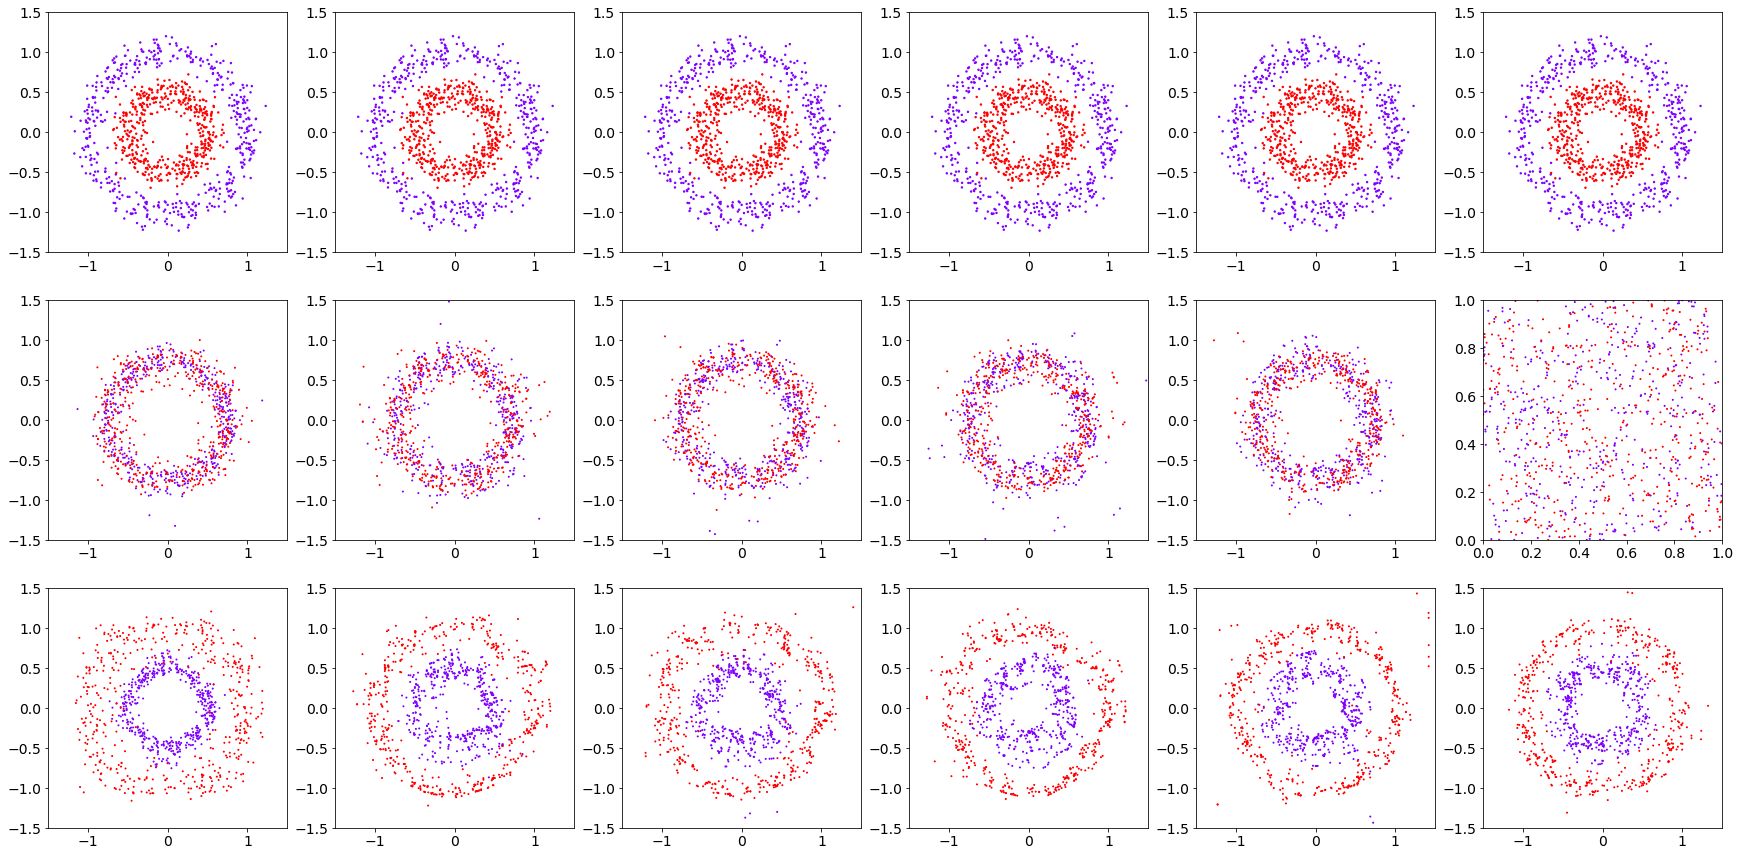

In [171]:
Z_dict = dict()
Xflip_dict = dict()

print(list(cd_dict))
fig, axs = plt.subplots(3,6,figsize=(30,15))
i=0
for key, cd in cd_dict.items():
    if key in ['GB', 'NB', 'DD','tree']:
        Z_temp = cd.transform(X, y)
        Xflip_temp = cd.inverse_transform(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp
    else:
        Z_temp = cd(X, y)
        Xflip_temp = cd.inverse(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp 
    
    axs[0,i].scatter(*X.T, c=y, s=2, cmap='rainbow')
    #axs[0,i].set_title('Original Test')

    try:
        axs[1,i].scatter(*Z_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[1,i].scatter(*Z_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')
    try:
        axs[2,i].scatter(*Xflip_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[2,i].scatter(*Xflip_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')

    axs[0,i].set_xlim(-1.5,1.5)
    axs[0,i].set_ylim(-1.5,1.5)
    axs[1,i].set_xlim(-1.5,1.5)
    axs[1,i].set_ylim(-1.5,1.5)
    axs[2,i].set_xlim(-1.5,1.5)
    axs[2,i].set_ylim(-1.5,1.5)
    axs[0,i].tick_params(labelsize=14)
    axs[2,i].tick_params(labelsize=14)
    axs[1,i].tick_params(labelsize=14)
    if key is 'DD':
        axs[1,i].set_xlim(0,1)
        axs[1,i].set_ylim(0,1)
    i += 1
plt.savefig(saving_dir + '/circle_flip.png', bbox_inches='tight')
plt.show()


NB


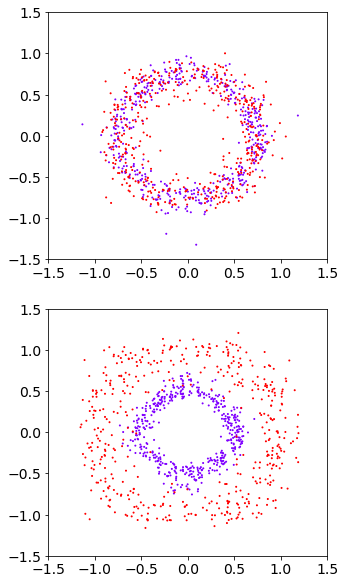

mSWD-NB


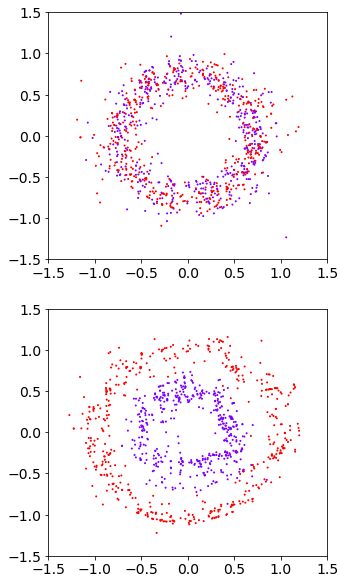

DD


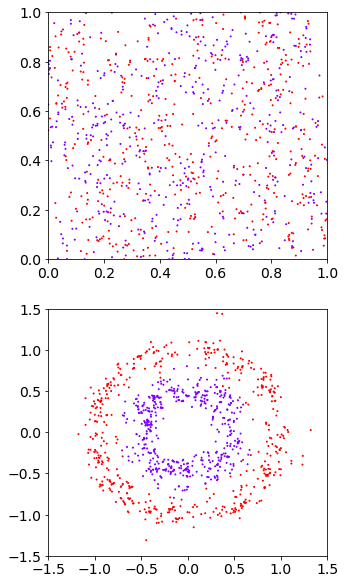

In [172]:
def gen_plot(cd_dict, key, X, y, path, show=False):
    print(key)
    cd = cd_dict[key]
    fig, axs = plt.subplots(2,1,figsize=(5,10))
    if key in ['GB', 'NB', 'DD','tree']:
        Z_temp = cd.transform(X, y)
        Xflip_temp = cd.inverse_transform(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp
    else:
        Z_temp = cd(X, y)
        Xflip_temp = cd.inverse(Z_temp, 1 - y)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp 

    axs[0].tick_params(labelsize=14)
    axs[1].tick_params(labelsize=14)
    axs[0].set_xlim(-1.5,1.5)
    axs[0].set_ylim(-1.5,1.5)
    axs[1].set_xlim(-1.5,1.5)
    axs[1].set_ylim(-1.5,1.5)
    if key is 'DD':
        axs[0].set_xlim(0,1)
        axs[0].set_ylim(0,1)
    try:
        axs[0].scatter(*Z_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[0].scatter(*Z_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')
    try:
        axs[1].scatter(*Xflip_temp.T, c=y, s=1, cmap='rainbow')
    except:
        axs[1].scatter(*Xflip_temp.T.detach().numpy(), c=y, s=1, cmap='rainbow')
    plt.savefig(saving_dir + path, bbox_inches='tight')
    plt.show()

gen_plot(cd_dict,'NB',X,y,'/circle_nb.png')
gen_plot(cd_dict,'mSWD-NB',X,y,'/circle_swdnb.png')
gen_plot(cd_dict,'DD',X,y,'/circle_dd.png')
#gen_plot(cd_dict,'tree',X,y,'/circle_tree.png')

### Transport Cost

transportation cost of NB is 0.060247235000133514
transportation cost of mSWD-NB is 0.08736918866634369
transportation cost of NB-mSWD-NB is 0.09561070799827576
transportation cost of Rand-NB is 0.07660774886608124
transportation cost of NB-Rand-NB is 0.1103312224149704
transportation cost of DD is 1.2579619884490967


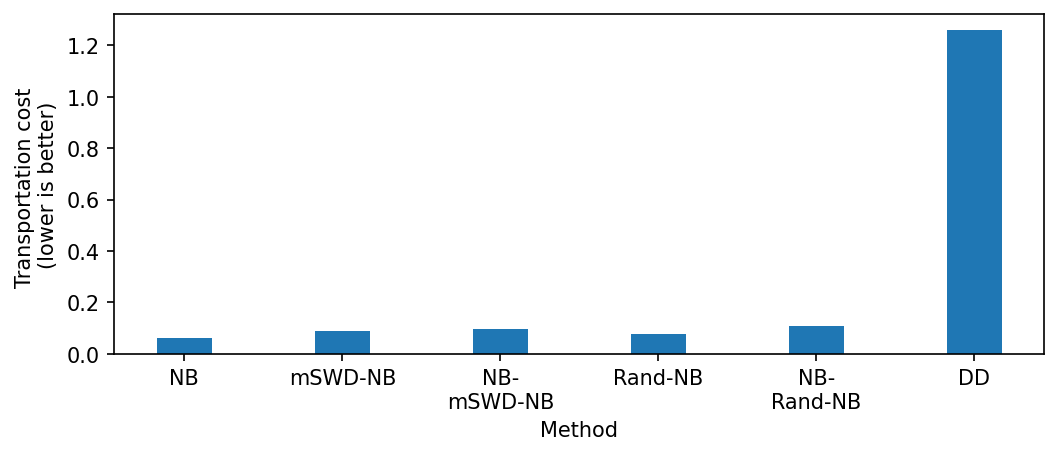

In [173]:
cost_dict = dict()
for key,Z in Z_dict.items():
    cost_temp = transport_cost(X, Z, y)
    cost_dict[key] = cost_temp
    print('transportation cost of '+key+f' is {cost_temp}')
    
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = [ 'NB', 'mSWD-NB', 'NB-\nmSWD-NB', 'Rand-NB', 'NB-\nRand-NB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(cost_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Transportation cost \n(lower is better)')
plt.show()

### Pushforward Constraint

2-wasserstein distance of NB in the latent space is 0.00479460321366787
2-wasserstein distance of mSWD-NB in the latent space is 0.021368063986301422
2-wasserstein distance of NB-mSWD-NB in the latent space is 0.020984861999750137
2-wasserstein distance of Rand-NB in the latent space is 0.024053245782852173
2-wasserstein distance of NB-Rand-NB in the latent space is 0.04071129113435745
2-wasserstein distance of DD in the latent space is 0.0010775976115837693


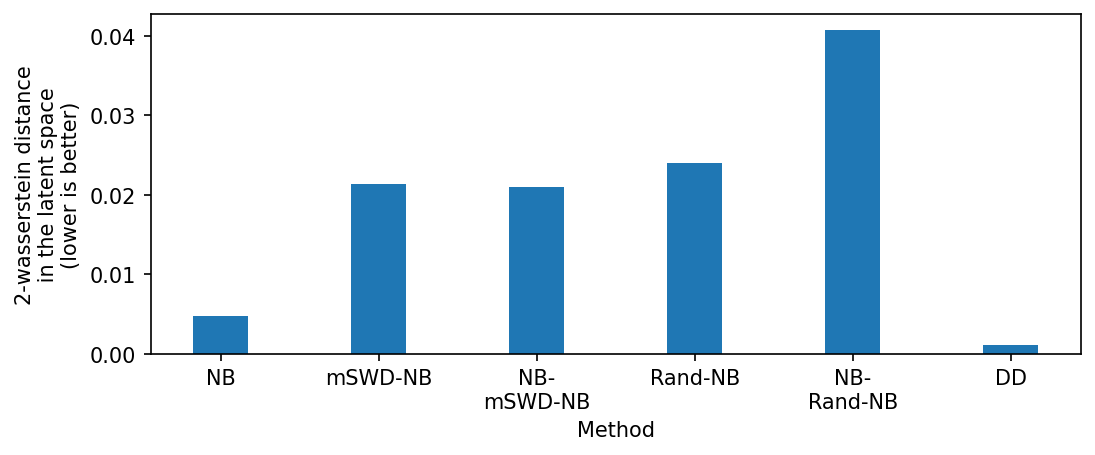

In [174]:
latentwd_dict = dict()
for key,Z in Z_dict.items():
    wd_temp = wd_sinkhorn(Z, y, n_samples).detach().numpy()
    latentwd_dict[key] = wd_temp
    print('2-wasserstein distance of '+key+f' in the latent space is {wd_temp}')

fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = [ 'NB', 'mSWD-NB', 'NB-\nmSWD-NB', 'Rand-NB', 'NB-\nRand-NB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(latentwd_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('2-wasserstein distance\n in the latent space \n(lower is better)')
plt.show()

2-wasserstein distance of NB in the original space is 0.004159860895015299
2-wasserstein distance of mSWD-NB in the original space is 0.005133030121214688
2-wasserstein distance of NB-mSWD-NB in the original space is 0.007232561940327287
2-wasserstein distance of Rand-NB in the original space is 0.0027594842249527574
2-wasserstein distance of NB-Rand-NB in the original space is 0.007842779392376542
2-wasserstein distance of DD in the original space is 0.0029386766254901886


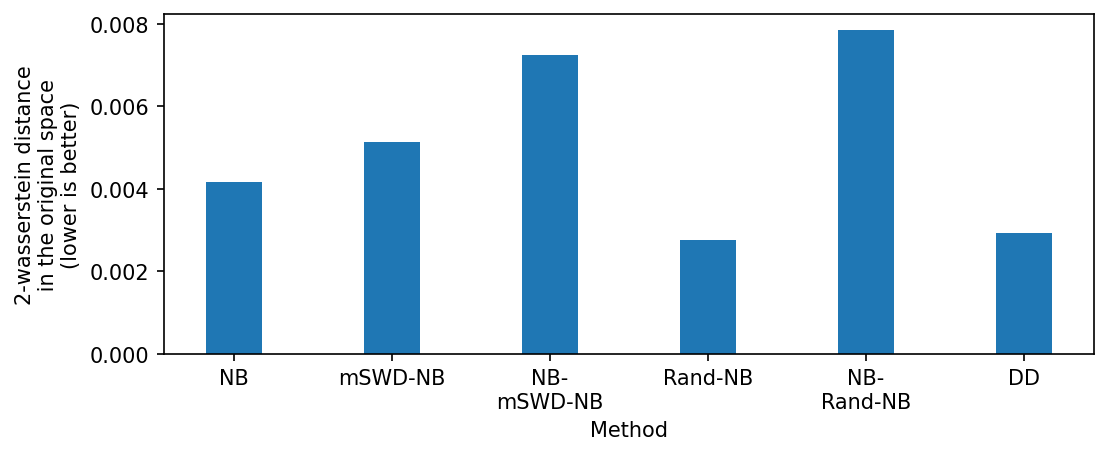

In [175]:
oriwd_dict = dict()
for key,Xflip in Xflip_dict.items():
    wd_temp = wd_average(X, Xflip, y, n_samples)
    oriwd_dict[key] = wd_temp
    print('2-wasserstein distance of '+key+f' in the original space is {wd_temp}')

fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = [ 'NB', 'mSWD-NB', 'NB-\nmSWD-NB', 'Rand-NB', 'NB-\nRand-NB', 'DD']
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(oriwd_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('2-wasserstein distance\n in the original space \n(lower is better)')
plt.show()